# Detecção de Mudanças

Escolhendo uma cidade: Águas Claras


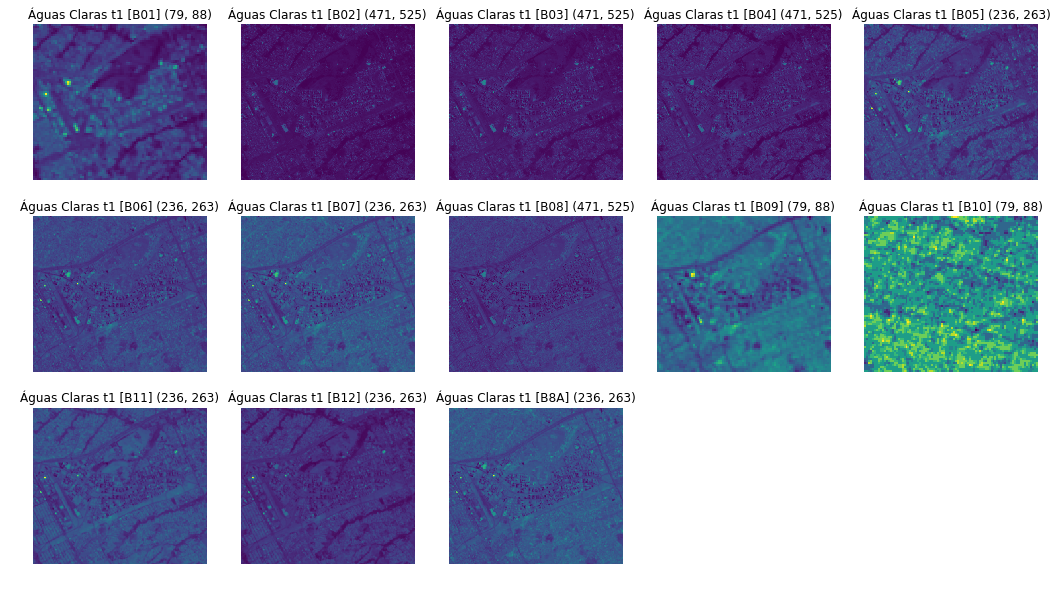

In [88]:
import glob
from skimage import io
import matplotlib.pyplot as plt
import numpy as np


def get_spectral_band_from_image_name(image_name):
    '''
    
    Exemplo de nome de imagem: S2A_OPER_MSI_L1C_TL_SGS__20160927T081713_A006607_T49QHE_B01.tif
    '''
    import re

    match = re.search(r"_(B[\da-zA-Z]{2})\.tif", image_name, re.I)
    if (match == None):
        return None
    return match.group(1)


def import_all_files_from_directory(path):
    '''
    Carrega todas as imagens do diretório especificado.
    Retorna, para cada imagem, uma tupla contendo:
        - um np.ndarray com seu conteúdo
        - uma string informando a banda espectral amostrada na imagem
    '''
    images = []
    for filename in glob.glob('{}/*.tif'.format(path)):
        image = io.imread(filename)
        band = get_spectral_band_from_image_name(filename)
        images.append((image, band))

    return images

def show_all_bands(images, title=''):
    fig, axes = plt.subplots(3, 5, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, image in enumerate(images):
        axes[i].imshow(image[0])
        axes[i].set_title('{} [{}] {}'.format(title, image[1], image[0].shape))

    for ax in axes:
        ax.set_axis_off()
    
    plt.show()

def show_compare(left, right, left_title='', right_title=''):
    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(18, 12))
    left_ax.imshow(left)
    left_ax.set_axis_off()
    left_ax.set_title('{} {}'.format(left_title, left.shape))
    right_ax.imshow(right)
    right_ax.set_axis_off()
    right_ax.set_title('{} {}'.format(right_title, right.shape))
    plt.show()
    
def show(image):
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    ax.imshow(image)
    ax.set_axis_off()
    plt.show()
    
aguasclaras_sources = import_all_files_from_directory('onera-images/aguasclaras/imgs_1')
aguasclaras_targets = import_all_files_from_directory('onera-images/aguasclaras/imgs_2')
aguasclaras_ground_truth = io.imread('onera-labels/aguasclaras/cm/cm.png')[:, :, 0]
show_all_bands(aguasclaras_sources, 'Águas Claras t1') 


Reescalando todas as bandas para que tenham o mesmo tamanho (da maior)

In [66]:
from skimage.transform import rescale

def rescale_bands(image_sources):
    largest_shape = max(list(map(lambda band_tuple: band_tuple[0].shape, image_sources)))
    largest_shape = largest_shape + (len(image_sources),)
    single_image = np.ndarray(largest_shape)
    for i, band in enumerate(image_sources):
        rescale_ratio = largest_shape[0] / band[0].shape[0]
        single_image[:, :, i] = rescale(band[0], rescale_ratio, anti_aliasing=True)

    return single_image  
    

aguasclaras_single_image_t1 = rescale_bands(aguasclaras_sources)
aguasclaras_single_image_t2 = rescale_bands(aguasclaras_targets)


## Resolvendo com _image differencing_

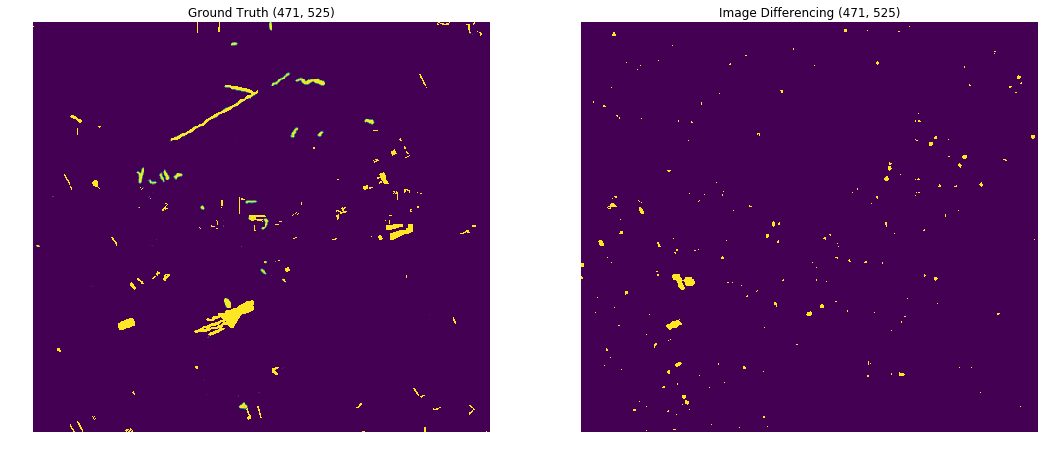

In [112]:
def generate_image_differencing(time1, time2, threshold=0.035):
    difference_image = abs(time1 - time2)
    binary_image = np.ndarray((time1.shape[0], time1.shape[1]))
    binary_image = np.any(difference_image[:, :] > threshold, axis=2)
    binary_image = binary_image.astype('float')
    return binary_image

aguasclaras_difference_image = generate_image_differencing(aguasclaras_single_image_t1, aguasclaras_single_image_t2)
show_compare(aguasclaras_ground_truth, aguasclaras_difference_image, 'Ground Truth', 'Image Differencing')


Comparando com o _ground truth_

In [113]:
from skimage import measure

def get_comparison_indices(truth, test_image):
    mse = measure.compare_nrmse(truth, test_image)
    ssim = measure.compare_ssim(truth, test_image)
    difference = abs(truth - test_image)
    different_pixels = difference[difference > 0].shape[0]
    all_pixels = truth.shape[0] * truth.shape[1]
    accuracy = (all_pixels - different_pixels) / all_pixels
    return {'mse': mse, 'ssim': ssim, 'accuracy': accuracy}

aguasclaras_accuracy = get_comparison_indices(aguasclaras_ground_truth, aguasclaras_difference_image)
print("{:<20} {:<25} {:<25}".format('Cidade','Image Differencing (ssim)','Image Differencing (acc)'))
# for k, v in aguasclaras_accuracy.items():
print("{:<20} {:<25} {:<25}".format('aguasclaras', aguasclaras_accuracy.get('ssim'), aguasclaras_accuracy.get('accuracy')))


Cidade               Image Differencing (ssim) Image Differencing (acc) 
aguasclaras          0.9244783015601045        0.9765645536346174       


Gerando uma única imagem (3 bandas) usando PCA

In [ ]:
def generate_pca3_image_from_13_bands(bands):
    
    

Segmentando a imagem PCA usando SLIC

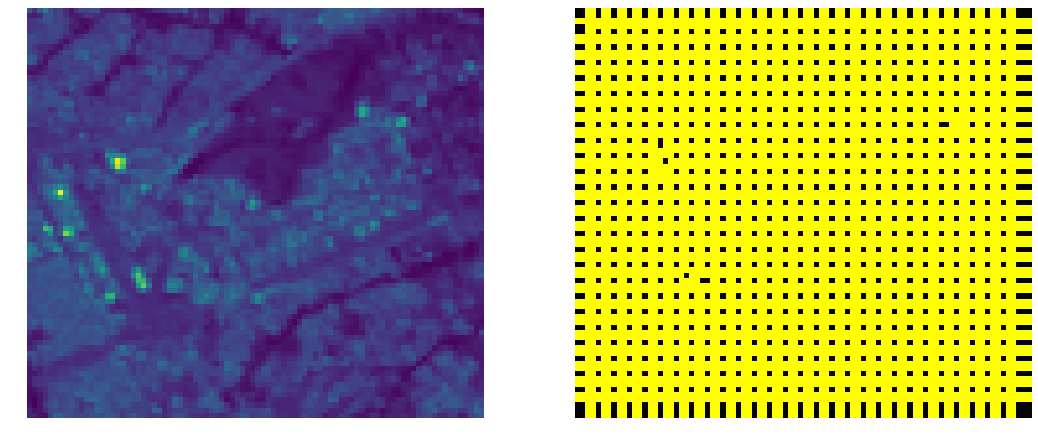

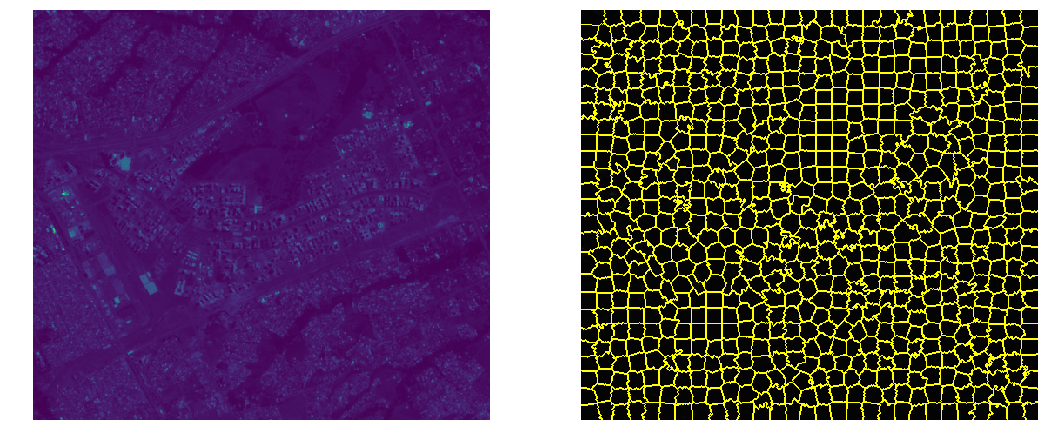

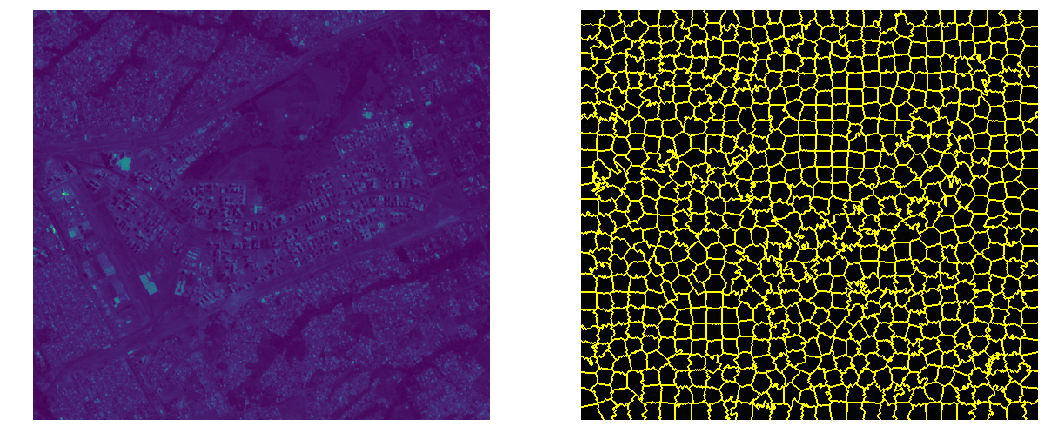

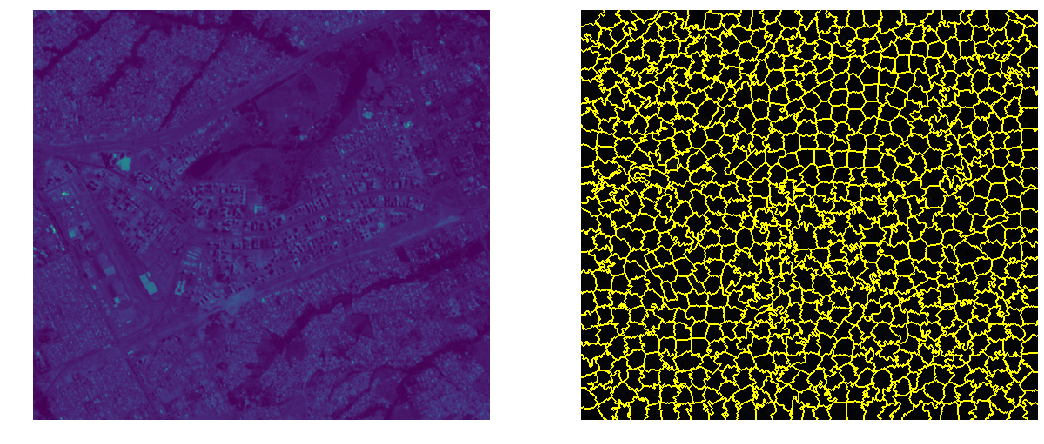

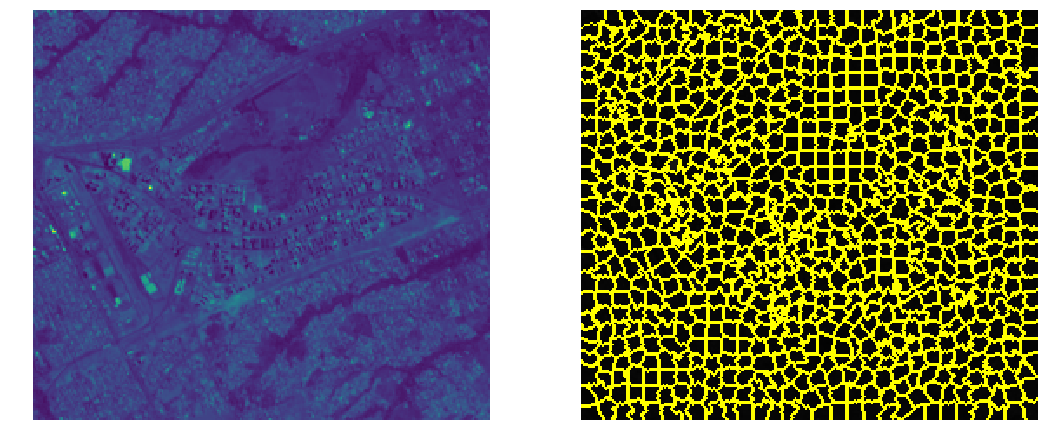

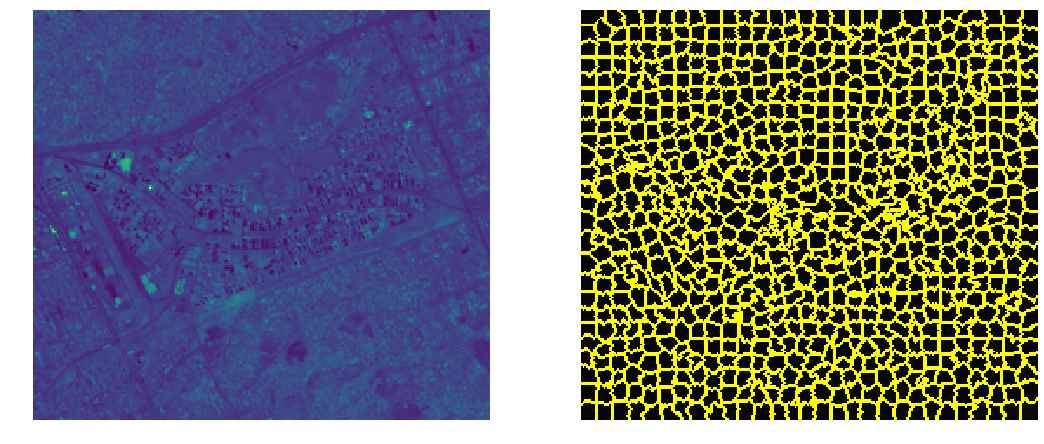

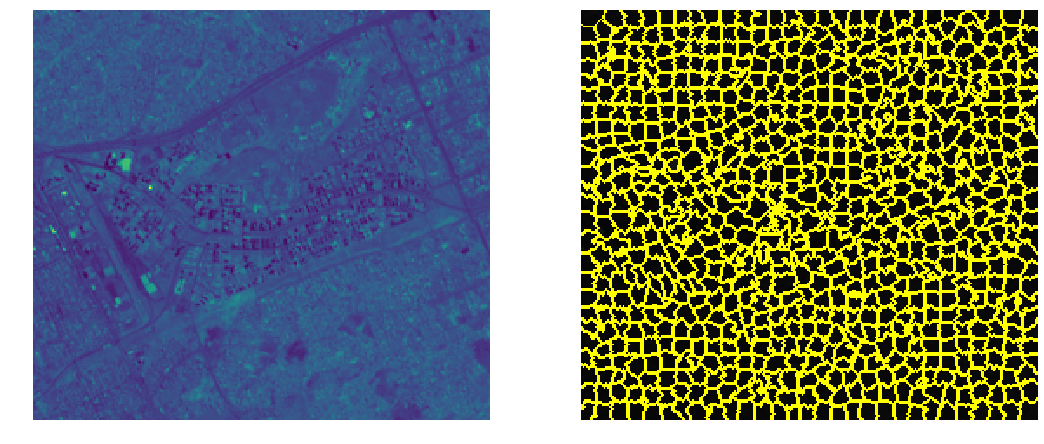

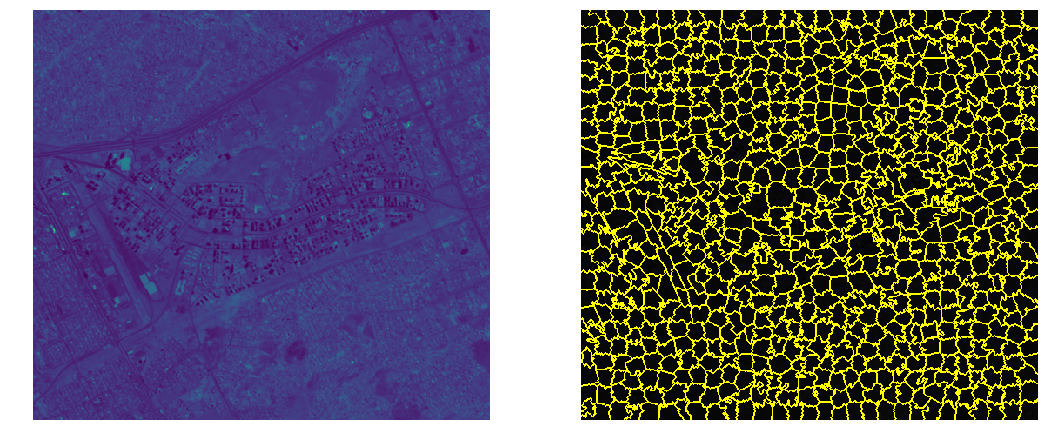

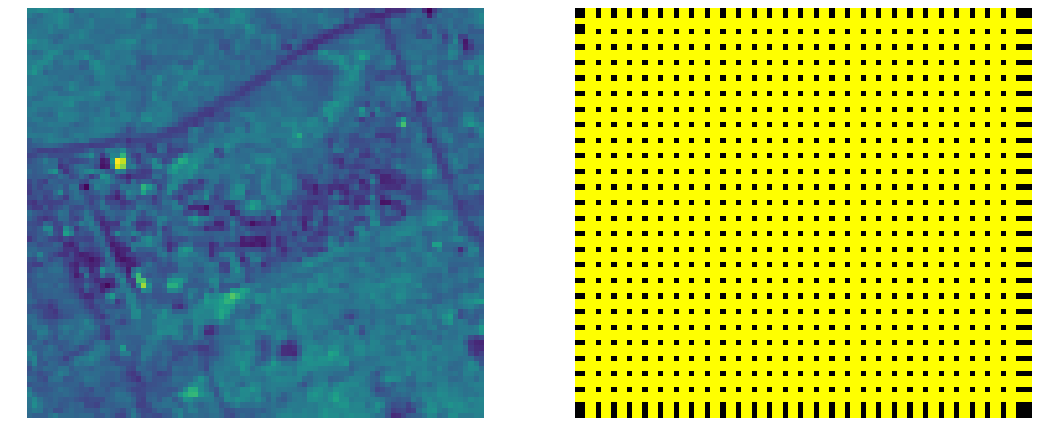

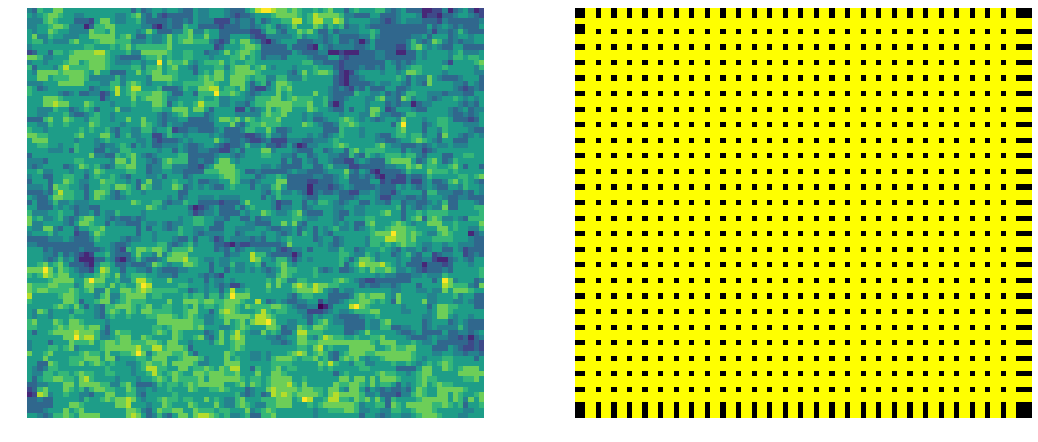

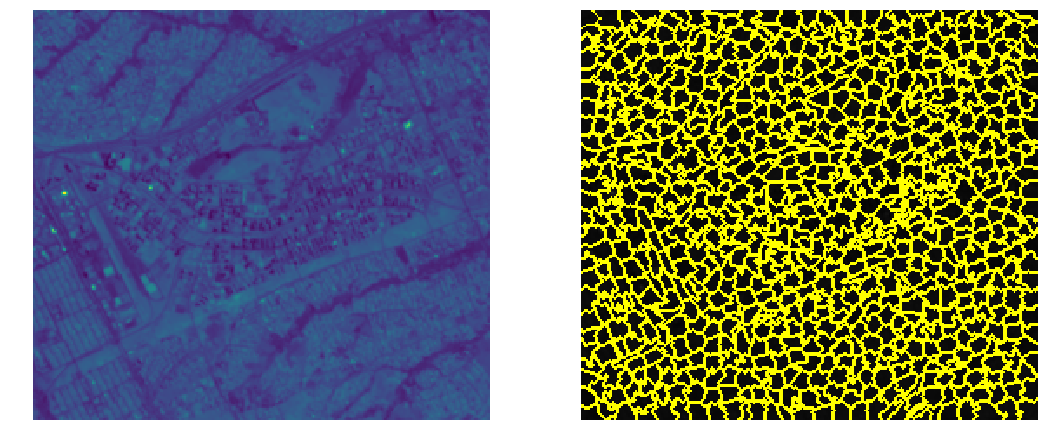

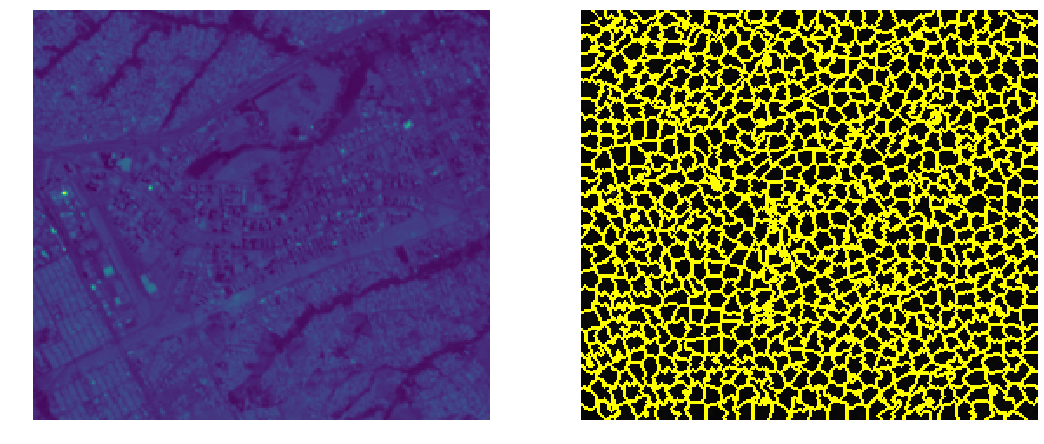

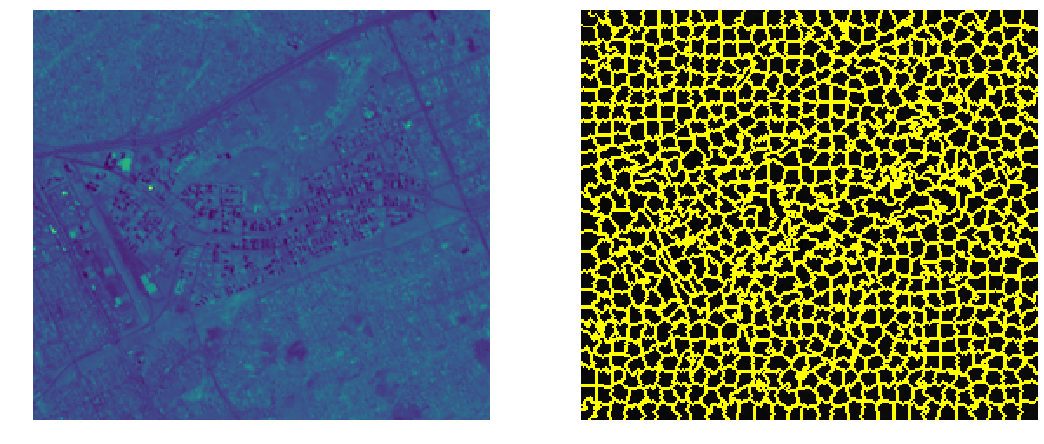

In [4]:
def show_compare(left, right):
    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(18, 12))
    left_ax.imshow(left)
    left_ax.set_axis_off()
    right_ax.imshow(right)
    right_ax.set_axis_off()
    plt.show()
    

    
# computando o SLIC
from skimage import img_as_float
from skimage import segmentation
from skimage import color

slic_out = []

for (banda, nome) in aguasclaras_sources:
  labels = segmentation.slic(banda, compactness=0.01, n_segments=800, sigma=0)
  out = color.label2rgb(labels, banda, kind='avg')
  slic_out.append(out)
  show_compare(banda, segmentation.mark_boundaries(banda, labels))




In [ ]:
def show_image_and_hist(image, title):
    # pega parâmetros da imagem
    channels = image.shape[2] if len(image.shape) > 2 else 1
    is_colored = channels > 1

    # cria uma figura com espaço para a imagem e para o histograma
    figure, axes = plt.subplots(1, 2, figsize=(18, 5))
    image_axis, histogram_axis = axes

    # coloca a imagem em seu subplot
    image_axis.imshow(image, cmap='gray')
    image_axis.set_axis_off()
    image_axis.set_title('{} {}'.format(title, image.shape))

    # coloca o histograma em seu subplot
    if is_colored:
        channel_colors = ['red', 'green', 'blue']
        for i, c in enumerate(channel_colors):
            histogram_axis.hist(image[:, :, i].flatten(), bins=256, lw=1, color=c, histtype='step')
    else:
        histogram_axis.hist(image.ravel(), bins=256, lw=0, histtype='bar')
    histogram_axis.set_xlim(0, image.max())
    histogram_axis.set_yticks([])

    plt.show()
    

def show(img, cmap=None):
    cmap = cmap or plt.cm.gray
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(img, cmap=cmap)
    ax.set_axis_off()
    plt.show()
    
for (banda) in slic_out:
  show_image_and_hist(banda, 'Águas Claras')
